In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud


nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentimentdataset.csv")

In [14]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [15]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,Unnamed: 0.1,int64,0,0.000000
1,Unnamed: 0,int64,0,0.000000
2,Text,object,0,0.000000
3,Sentiment,object,0,0.000000
4,Timestamp,object,0,0.000000
5,User,object,0,0.000000
6,Platform,object,0,0.000000
7,Hashtags,object,0,0.000000
8,Retweets,float64,0,0.000000
9,Likes,float64,0,0.000000


In [16]:
df.duplicated().sum()

0

In [17]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [18]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Unnamed: 0.1: 732 distinct values
Unnamed: 0: 732 distinct values
Text: 707 distinct values
Sentiment: 279 distinct values
Timestamp: 683 distinct values
User: 685 distinct values
Platform: 4 distinct values
Hashtags: 697 distinct values
Retweets: 26 distinct values
Likes: 38 distinct values
Country: 115 distinct values
Year: 14 distinct values
Month: 12 distinct values
Day: 31 distinct values
Hour: 22 distinct values


In [19]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags','Day', 'Hour','Sentiment'])

In [20]:
df['Platform'].value_counts()

Platform
 Instagram     258
 Facebook      231
 Twitter       128
 Twitter       115
Name: count, dtype: int64

In [21]:
df['Platform'] = df['Platform'].str.strip()

In [22]:
df['Country'].value_counts()

Country
 USA               59
 USA               55
 UK                49
 Canada            44
 Australia         41
                   ..
 Netherlands        1
 USA                1
 Germany            1
 France             1
 USA                1
Name: count, Length: 115, dtype: int64

In [23]:
df['Country'] = df['Country'].str.strip()

In [24]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [25]:
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

In [26]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = " ".join(text.split())
    tokens = word_tokenize(text)

    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]

    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

In [27]:
df1 = df.copy()

In [28]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                     Clean_Text  Vader_Score Sentiment
0         enjoy beauti day park       0.4939  positive
1          traffic terribl morn       0.0000   neutral
2           finish amaz workout       0.0000   neutral
3   excit upcom weekend getaway       0.0000   neutral
4  tri new recip dinner tonight       0.0000   neutral


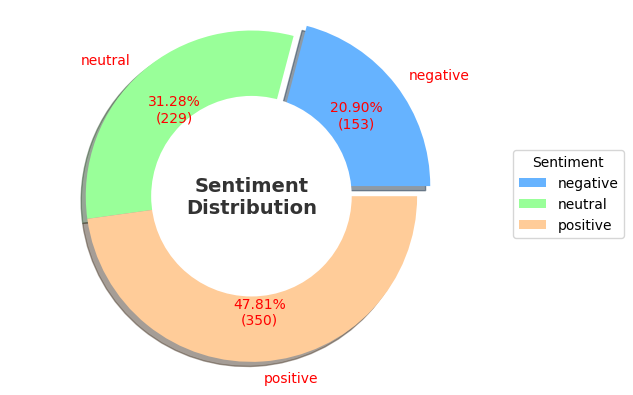

In [29]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

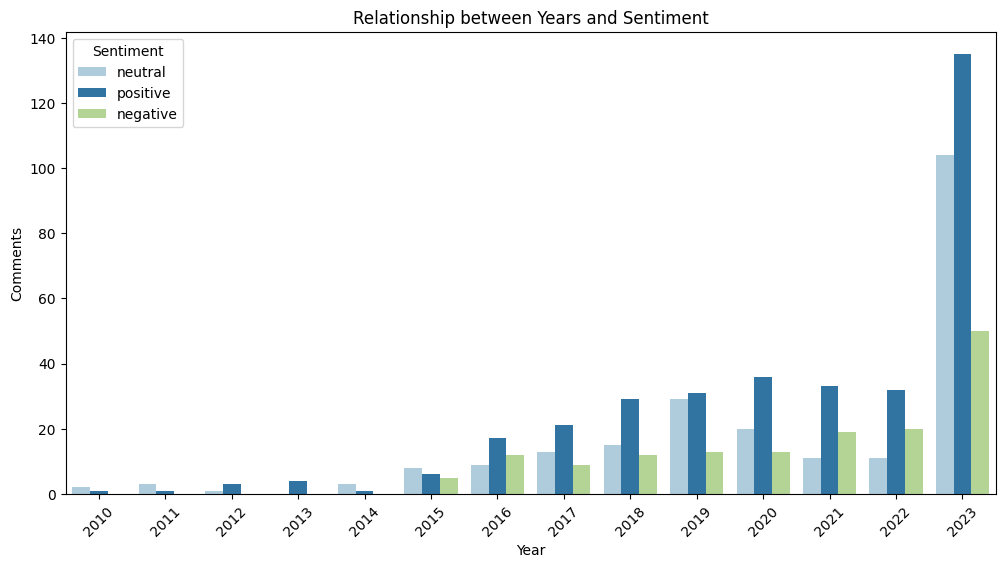

In [30]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Comments')
plt.xticks(rotation=45)
plt.show()

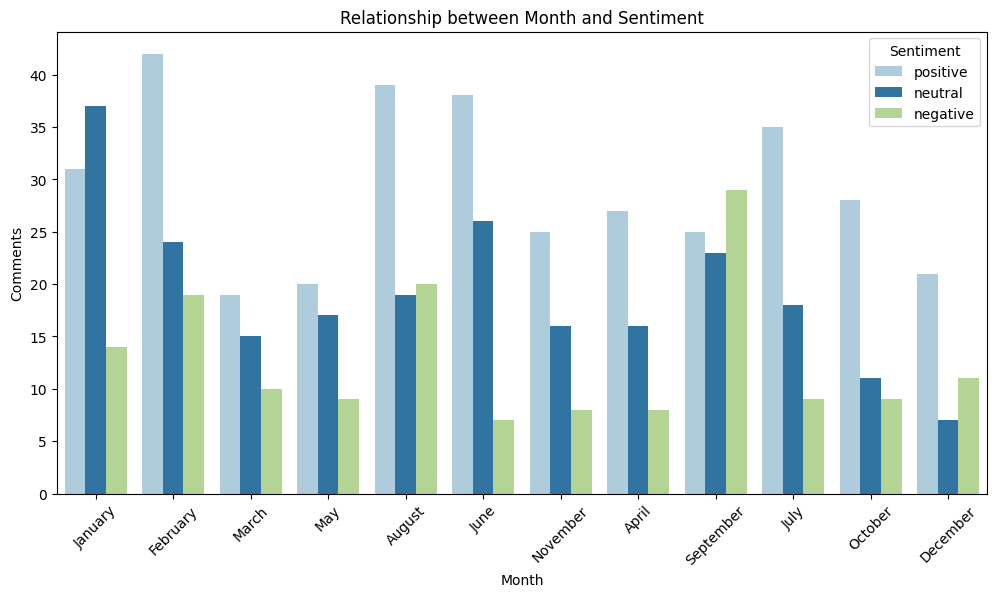

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Comments')
plt.xticks(rotation=45)
plt.show()

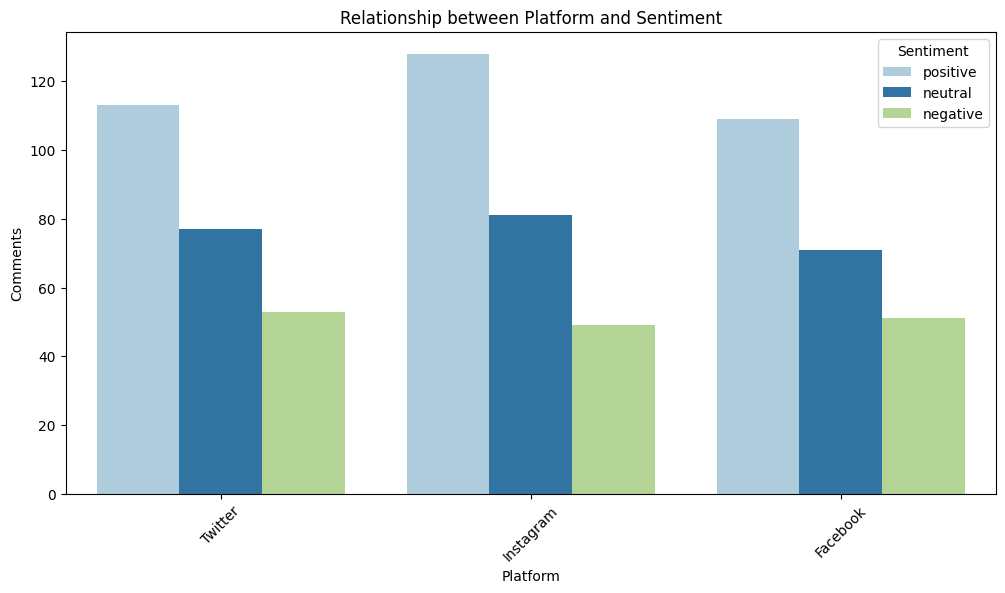

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Comments')
plt.xticks(rotation=45)
plt.show()

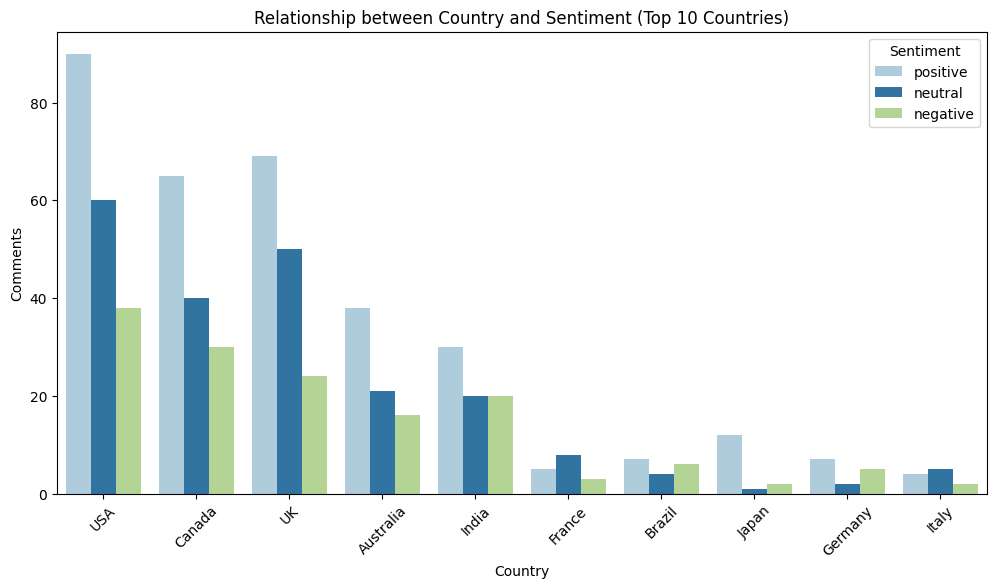

In [33]:
plt.figure(figsize=(12, 6))

top_10_countries = df1['Country'].value_counts().head(10).index

df_top_10_countries = df1[df1['Country'].isin(top_10_countries)]

sns.countplot(x='Country', hue='Sentiment', data=df_top_10_countries, palette='Paired')
plt.title('Relationship between Country and Sentiment (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Comments')
plt.xticks(rotation=45)
plt.show()

In [34]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')


,Common_words,count
0,new,43
1,life,37
2,challeng,34
3,joy,31
4,danc,30
5,day,29
6,feel,29
7,like,28
8,dream,28
9,moment,27


In [35]:
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']


In [36]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')


,Common_words,count
0,joy,30
1,friend,24
2,laughter,24
3,new,21
4,challeng,20
5,life,20
6,hope,20
7,dream,20
8,embrac,19
9,like,19


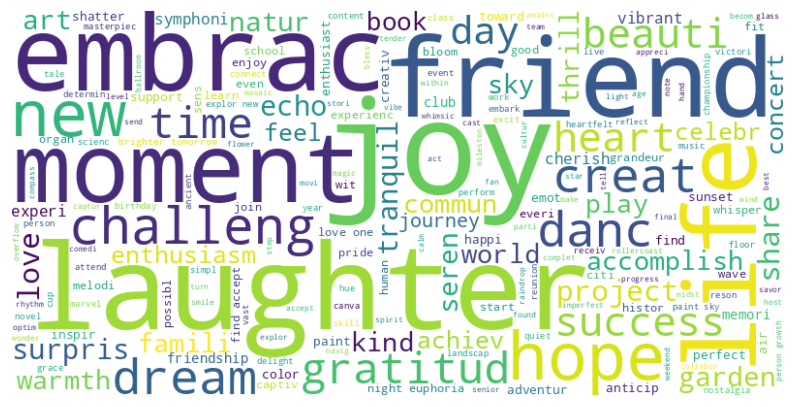

In [37]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [38]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')


,Common_words,count
0,new,22
1,explor,13
2,excit,12
3,life,12
4,beauti,12
5,night,12
6,danc,12
7,attend,11
8,seren,11
9,feel,10


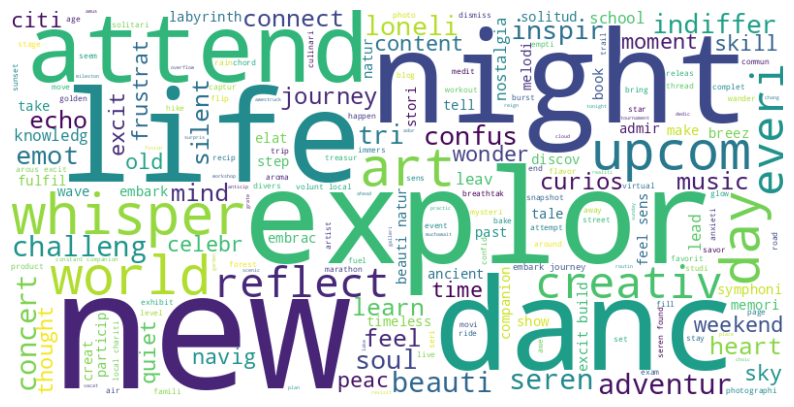

In [39]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [40]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')


,Common_words,count
0,despair,14
1,lost,14
2,emot,13
3,feel,11
4,bitter,10
5,storm,10
6,day,9
7,like,9
8,grief,8
9,heart,8


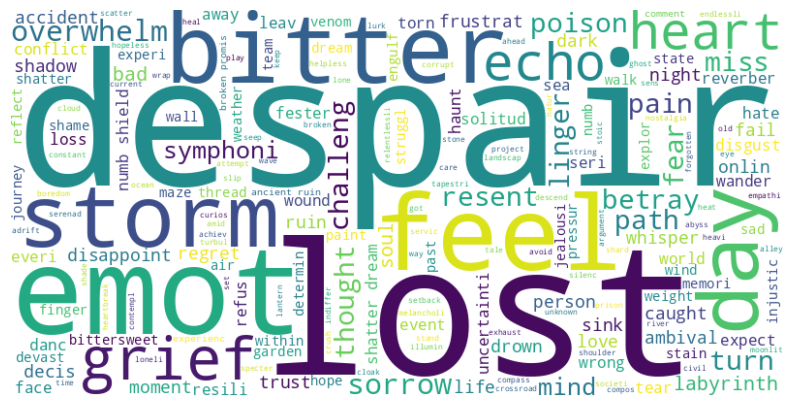

In [41]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [42]:
df2 = df1.copy()

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [44]:
X = df2['Clean_Text'].values
y = df2['Sentiment'].values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [47]:
param_dist = {
    'C': [0.1, 1.0],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'verbose': [0, 1],
}

In [48]:
pac_classifier = PassiveAggressiveClassifier(random_state=42)

randomized_search = RandomizedSearchCV(pac_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
randomized_search.fit(X_train_tfidf, y_train)

Streaming output truncated to the last 5000 lines.
Norm: 15.18, NNZs: 1570, Bias: -0.331894, T: 6552, Avg. loss: 0.033786
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 15.51, NNZs: 1570, Bias: -0.336854, T: 7020, Avg. loss: 0.027724
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 15.75, NNZs: 1570, Bias: -0.334385, T: 7488, Avg. loss: 0.019814
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 15.92, NNZs: 1570, Bias: -0.333776, T: 7956, Avg. loss: 0.014919
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 16.05, NNZs: 1570, Bias: -0.332383, T: 8424, Avg. loss: 0.011218
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 16.16, NNZs: 1570, Bias: -0.332902, T: 8892, Avg. loss: 0.009202
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 16.26, NNZs: 1570, Bias: -0.336037, T: 9360, Avg. loss: 0.007249
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 16.32, NNZs: 1570, Bias: -0.336304, T: 9828, Avg. loss: 0.005206
Total training time: 0.03 seconds.
-- Epoch 22
Norm:

RandomizedSearchCV(cv=5, estimator=PassiveAggressiveClassifier(random_state=42),
                   param_distributions={'C': [0.1, 1.0],
                                        'fit_intercept': [True, False],
                                        'shuffle': [True, False],
                                        'verbose': [0, 1]},
                   random_state=42, scoring='accuracy')

In [49]:
best_params_randomized = randomized_search.best_params_
best_params_randomized

{'verbose': 1, 'shuffle': False, 'fit_intercept': True, 'C': 1.0}

In [50]:
best_pac_classifier_randomized = PassiveAggressiveClassifier(random_state=42, **best_params_randomized)
best_pac_classifier_randomized.fit(X_train_tfidf, y_train)

-- Epoch 1
Norm: 15.52, NNZs: 1638, Bias: -0.388909, T: 585, Avg. loss: 0.473099
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 17.67, NNZs: 1661, Bias: -0.395184, T: 1170, Avg. loss: 0.083296
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 18.33, NNZs: 1666, Bias: -0.403558, T: 1755, Avg. loss: 0.023532
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 18.53, NNZs: 1669, Bias: -0.403081, T: 2340, Avg. loss: 0.006641
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 18.58, NNZs: 1669, Bias: -0.403129, T: 2925, Avg. loss: 0.001757
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 18.60, NNZs: 1669, Bias: -0.403437, T: 3510, Avg. loss: 0.000489
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 18.60, NNZs: 1669, Bias: -0.403497, T: 4095, Avg. loss: 0.000134
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 18.60, NNZs: 1669, Bias: -0.403486, T: 4680, Avg. loss: 0.000035
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 18.60, NNZs: 1669, Bias: -0.403480, T: 5265, Avg

PassiveAggressiveClassifier(random_state=42, shuffle=False, verbose=1)

In [51]:
y_pred_best_pac_randomized = best_pac_classifier_randomized.predict(X_test_tfidf)

In [52]:
accuracy_best_pac_randomized = accuracy_score(y_test, y_pred_best_pac_randomized)
classification_rep_best_pac_randomized = classification_report(y_test, y_pred_best_pac_randomized)
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_randomized)

In [53]:
print("Best PassiveAggressiveClassifier Model (RandomizedSearchCV):")
print(f"Best Hyperparameters: {best_params_randomized}")
print(f"Accuracy: {accuracy_best_pac_randomized}")
print("Classification Report:\n", classification_rep_best_pac_randomized)


Best PassiveAggressiveClassifier Model (RandomizedSearchCV):
Best Hyperparameters: {'verbose': 1, 'shuffle': False, 'fit_intercept': True, 'C': 1.0}
Accuracy: 0.7278911564625851
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.81      0.83        32
     neutral       0.74      0.56      0.64        55
    positive       0.68      0.83      0.75        60

    accuracy                           0.73       147
   macro avg       0.75      0.74      0.74       147
weighted avg       0.73      0.73      0.72       147



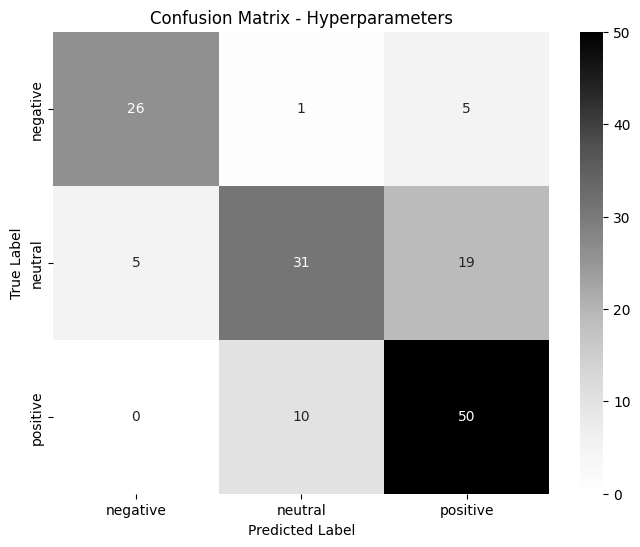

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greys', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Hyperparameters')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
